## The Basic Idea of Machine Learning

## Auto-encoder

#### Reference:
  1. [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder).

## Implementation

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
data_path = '../../dat/MNIST/'
mnist = input_data.read_data_sets(
    data_path, one_hot=True,
    source_url='http://yann.lecun.com/exdb/mnist/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../dat/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../dat/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../dat/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../dat/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
def get_encoder(latent_dim, hidden_layers):
    
  def encoder(x, name='encoder', reuse=None):
    with tf.variable_scope(name, reuse=reuse):
      hidden = x
      for hidden_layer in hidden_layers:
        hidden = tf.layers.dense(hidden, hidden_layer,
                                 activation=tf.nn.relu)
      latent = tf.layers.dense(hidden, latent_dim, activation=None)
      return latent
    
  return encoder

In [4]:
def get_decoder(observable_dim, hidden_layers):
    
  def decoder(latent, name='decoder', reuse=None):
    with tf.variable_scope(name, reuse=reuse):
      hidden = latent
      for hidden_layer in hidden_layers:
        hidden = tf.layers.dense(hidden, hidden_layer,
                                 activation=tf.nn.relu)
      reconstructed = tf.layers.dense(hidden, observable_dim,
                                      activation=tf.nn.sigmoid)
      return reconstructed
    
  return decoder

In [5]:
def get_loss(observable, encoder, decoder, regularizer=None, reuse=None):
  if regularizer is None:
    regularizer = lambda latent: 0.0
    
  with tf.name_scope('loss'):
    # shape: [batch_size, latent_dim]
    latent = encoder(observable, reuse=reuse)
    # shape: [batch_size, observable_dim]
    reconstructed = decoder(latent, reuse=reuse)
    # shape: [batch_size]
    squared_errors = tf.reduce_sum(
        (reconstructed - observable) ** 2,
        axis=1)
    mean_square_error = tf.reduce_mean(squared_errors)
    return mean_square_error + regularizer(latent)

In [6]:
latent_dim = 32
encoder = get_encoder(latent_dim=latent_dim,
                      hidden_layers=[512, 512])
decoder = get_decoder(observable_dim=28*28,
                      hidden_layers=[512, 512])
observable = tf.placeholder(shape=[None, 28*28],
                            dtype='float32',
                            name='observable')
latent_samples = tf.placeholder(shape=[None, latent_dim],
                                dtype='float32',
                                name='latent_samples')
generated = decoder(latent_samples, reuse=tf.AUTO_REUSE)

In [7]:
def regularizer(latent, name='regularizer'):
  with tf.name_scope(name):
    distances = tf.reduce_sum(latent ** 2, axis=1)
    return tf.reduce_mean(distances)

In [8]:
loss = get_loss(observable, encoder, decoder,
                regularizer=regularizer,
                reuse=tf.AUTO_REUSE)

In [9]:
train_op = tf.train.AdamOptimizer().minimize(loss)

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [11]:
loss_vals = []
for i in tqdm(range(5000)):
  X, y = mnist.train.next_batch(batch_size=128)
  _, loss_val = sess.run([train_op, loss], {observable: X})
  loss_vals.append(loss_val)

100%|██████████| 5000/5000 [02:47<00:00, 29.94it/s]


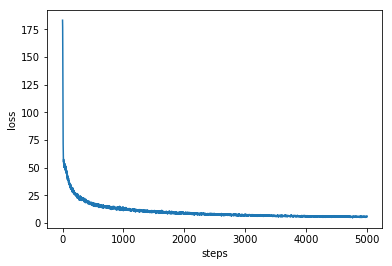

In [12]:
plt.plot(loss_vals)
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()

In [56]:
def get_image(array):
    array = np.where(array > 0.5,
                     np.ones_like(array),
                     np.zeros_like(array))
    array = array * 255
    array = array.reshape([28, 28]).astype('uint8')
    image = Image.fromarray(array)
    return image

In [61]:
latent_sample_vals = np.random.normal(size=[1, latent_dim])
generated_vals = sess.run(generated, {latent_samples: latent_sample_vals})
image = get_image(generated_vals[0])
image.show()